# Object Detection with FasterRCNN-MobileNetV3
<br>Last updated on 12/02/2023</br>
    <br>We aim to detect objects consisting of 20 classes: person, bird, cat, dog, horse, sheep, aeroplane, bicycle, boat, bicycle, boat, bus, car, motorbike, train, bottle, chair, dining table, potted plant, sofa, and TV monitor. **Pascal VOC Detection Dataset** (http://host.robots.ox.ac.uk/pascal/VOC/) and **Faster RCNN with MobileNetV3 backbone** (https://towardsdatascience.com/faster-r-cnn-for-object-detection-a-technical-summary-474c5b857b46) are employed for the trial. The code is modified form https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html. <br>

## 1. Check the availability of CUDA (GPU-Nvidia)

In [ ]:
! nvidia-smi

Sun Feb 12 20:00:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchvision

device = 'cuda'
boxes = torch.tensor([[0., 1., 2., 3.]]).to(device)
scores = torch.randn(1).to(device)
iou_thresholds = 0.5

print(torchvision.ops.nms(boxes, scores, iou_thresholds))

tensor([0], device='cuda:0')


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
#print(torch.cuda.get_device_name(device))

cuda:0


## 2. Creating the model

Typically, data inspection is the first priority before model creation, but here, in this trial, we have to know the model's input and output to create our data loader promptly. Since the possible outcome is 20 classes, the final output classes of the model should be **21**, including the background.



In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

pretrain_weight = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights

# default num_classes = 91 from the pretrained model (COCO)
model_ft = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights = pretrain_weight)

# output layer with embedding vector of 1024 & #output classes = 21
model_ft.roi_heads.box_predictor = FastRCNNPredictor(1024, 21) #1

net = model_ft.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

**The code demonstrated our model's output; a list of dictionaries collecting keys of boxes, labels, and scores keys.** (evaluation mode)

In [ ]:
# train from off-the-shelf model (no fine-tune)
with torch.no_grad():
    net = net.eval()
    input_dummy = torch.rand(32, 3, 300, 400, dtype = torch.float32).to(device) # dummy input
    pred_dummy = net(input_dummy)
    print(len(pred_dummy))
    
# outputs are (1) boxes, (2) labels, (3) scores
pred_dummy[0]

32


{'boxes': tensor([], device='cuda:0', size=(0, 4)),
 'labels': tensor([], device='cuda:0', dtype=torch.int64),
 'scores': tensor([], device='cuda:0')}

**? cannbe used to open doc**

In [ ]:
net.forward?

In [ ]:
net

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

## 3. Data Loading, Transforming, Preparing, and Inspection

**We prepare to transform objects for our data transformation, consisting of "ToTensor" and "Normalize" for training, validation, and testing sets.**

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_train = transforms.Compose(
    [#transforms.Resize((230,230)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

transform = transforms.Compose(
    [#transforms.Resize((230,230)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

batch_size = 32

**Declare mapping dictionary of classes; mapping strings to integer numbers.**

In [ ]:
class_ = ["person", "bird", "cat", "cow", "dog", 
          "horse", "sheep", "aeroplane", "bicycle", "boat",
          "bus", "car", "motorbike", "train", "bottle",
          "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"]

textlabel2num = {x: i+1 for i, x in enumerate( class_)}
numlabel2text = {i+1: x for i, x in enumerate( class_)}
textlabel2num

{'person': 1,
 'bird': 2,
 'cat': 3,
 'cow': 4,
 'dog': 5,
 'horse': 6,
 'sheep': 7,
 'aeroplane': 8,
 'bicycle': 9,
 'boat': 10,
 'bus': 11,
 'car': 12,
 'motorbike': 13,
 'train': 14,
 'bottle': 15,
 'chair': 16,
 'diningtable': 17,
 'pottedplant': 18,
 'sofa': 19,
 'tvmonitor': 20}

**define our custom dataset class**

In [ ]:
import numpy as np

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return self.dataset.__len__()

    def __getitem__(self, idx):
        X, y = self.dataset.__getitem__(idx)
        
        labels = []
        boxes = []
        for item in y['annotation']['object']:
            labels.append(textlabel2num[item['name']])
            box = item['bndbox']
            boxes.append([np.float32(box["xmin"]),
                          np.float32(box["ymin"]),
                          np.float32(box["xmax"]),
                          np.float32(box["ymax"])])
        
        labels = torch.as_tensor(labels, dtype=torch.int64).to(device)
        boxes = torch.as_tensor(boxes, dtype=torch.float32).to(device)
        X = X.to(device)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return X, target

In [ ]:
# The function is used for aligning data to fit our model input.
def collate_fn(batch):
    X, y = tuple(zip(*batch))
    return list(X), list(y)

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown 12Ni-fMnBWtfKuQfsvCVj3NvHRfwRdsQF
!gdown 1vK1u_jkF7x0-muSe3tDAQJrFhnYfQtJA

In [ ]:
# Create training, validation, testing loader
trainset = torchvision.datasets.VOCDetection(root='./data', year='2007', image_set='train', download=True, transform=transform_train)
trainset = MyDataset(trainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

valset = torchvision.datasets.VOCDetection(root='./data', year='2007', image_set='val', download=True, transform=transform)
valset = MyDataset(valset)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

! tar -xf  /content/VOCtest_06-Nov-2007.tar -C /content/data
testset = torchvision.datasets.VOCDetection(root='./data', year='2007', image_set='test', transform=transform)
testset = MyDataset(testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


In [ ]:
# printout the number of samples in each set of data
trainset.__len__(), valset.__len__(), testset.__len__()

(2501, 2510, 4952)

In [ ]:
# Evaluate the speed of __getitem__ method
from tqdm.notebook import tqdm
for i in tqdm(range(trainset.__len__())):
    trainset.__getitem__(i)

  0%|          | 0/2501 [00:00<?, ?it/s]

In [ ]:
# Evaluate the speed of "dataloader"
for data in tqdm(trainloader):
    continue

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
# input & output (important)
trainset.__getitem__(0)

(tensor([[[-0.4588, -0.4824, -0.4745,  ..., -0.5686, -0.5765, -0.6000],
          [-0.4353, -0.4588, -0.4745,  ..., -0.5843, -0.6078, -0.5843],
          [-0.4902, -0.4745, -0.4667,  ..., -0.5294, -0.5294, -0.5451],
          ...,
          [-0.3961, -0.3882, -0.3804,  ..., -0.3412, -0.3333, -0.3412],
          [-0.3725, -0.3647, -0.3569,  ..., -0.3882, -0.3804, -0.3804],
          [-0.3569, -0.3490, -0.3490,  ..., -0.3725, -0.3804, -0.3804]],
 
         [[-0.4588, -0.4824, -0.4745,  ..., -0.5529, -0.5608, -0.5843],
          [-0.4353, -0.4588, -0.4745,  ..., -0.5686, -0.5922, -0.5686],
          [-0.4902, -0.4745, -0.4667,  ..., -0.5137, -0.5137, -0.5294],
          ...,
          [-0.4039, -0.3961, -0.3882,  ..., -0.3412, -0.3333, -0.3412],
          [-0.3804, -0.3725, -0.3647,  ..., -0.3882, -0.3804, -0.3804],
          [-0.3647, -0.3569, -0.3569,  ..., -0.3725, -0.3804, -0.3804]],
 
         [[-0.4745, -0.4980, -0.4902,  ..., -0.5608, -0.5686, -0.5922],
          [-0.4510, -0.4745,

**The code demonstrated our model's output; a list of losses.** (training mode)

In training mode, the model provides us with four types of loss: loss_classifier, loss_box_reg, loss_objectness, and loss_rpn_box_reg.

In [ ]:
net = net.to(device)
with torch.no_grad():
    for x, y in trainloader:
        net = net.train()
        # Please concentrate on this point. 
        # Since the training mode is active, the model needs both features and ground truth for computing loss of detection.
        loss = net(x,y)
        break
loss

{'loss_classifier': tensor(3.0160, device='cuda:0'),
 'loss_box_reg': tensor(0.5372, device='cuda:0'),
 'loss_objectness': tensor(0.0843, device='cuda:0'),
 'loss_rpn_box_reg': tensor(0.0161, device='cuda:0')}

**data inspection**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# functions to show an image
def imshow(imgs, labels, ncol):
    nrow = len(imgs) // ncol
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
    for row in range(nrow):
        for col in range(ncol):
            if row*ncol + col < len(imgs):
                img = imgs[row*ncol + col].cpu()*0.5 + 0.5
                img = img.permute((1, 2, 0)).mul(255).numpy()
                img = np.ascontiguousarray(img, dtype=np.uint8)
                
                boxes = labels[row*ncol + col]['boxes'].cpu().numpy()
                in_labels = labels[row*ncol + col]['labels'].cpu().numpy()
                nbox, _ = boxes.shape
                
                for i in range(nbox):
                    img = cv2.rectangle(img = img, 
                                        pt1 = (int(boxes[i][0]), int(boxes[i][1])), 
                                        pt2 = (int(boxes[i][2]), int(boxes[i][3])), 
                                        color = (0, 255, 0), 
                                        thickness = 2)
                    
                    img = cv2.putText(img = img, 
                                      text = f'{numlabel2text[in_labels[i]]}', 
                                      org = (int(boxes[i][0]) + 5, int(boxes[i][3]) - 5 ), 
                                      fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                                      fontScale = 1,
                                      color = (255, 255, 0), 
                                      thickness = 2, 
                                      lineType = cv2.LINE_AA)
                
                ax[row, col].imshow(img)
                ax[row, col].axis('off')
            else:
                ax[row, col].imshow(np.zeros((200,200, 3), dtype = np.uint8))
                ax[row, col].axis('off')
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
ncol = 4
imshow(images, labels, ncol)

Output hidden; open in https://colab.research.google.com to view.

**mIoU func**

In [ ]:
def single_iou(gt_box, pred_box):
    gt_box = gt_box.cpu()
    pred_box = pred_box.cpu()
    
    intersec_box = torch.tensor([
        max(gt_box[0], pred_box[0]),
        max(gt_box[1], pred_box[1]),
        min(gt_box[2], pred_box[2]),
        min(gt_box[3], pred_box[3]),
    ])
    
    intersec_w = max(intersec_box[2] - intersec_box[0],0)
    intersec_h = max(intersec_box[3] - intersec_box[1],0)
    intersec_area = intersec_w*intersec_h
    
    gt_w = gt_box[2] - gt_box[0]
    gt_h = gt_box[3] - gt_box[1]
    gt_area = gt_w*gt_h
    
    pred_w = pred_box[2] - pred_box[0]
    pred_h = pred_box[3] - pred_box[1]
    pred_area = pred_w*pred_h
    
    iou = intersec_area/(pred_area+gt_area-intersec_area)
        
    return iou

In [ ]:
def miou(pred, gt):
    mIoU = 0
    for i in range(len(gt)):
        pred_ = pred[i]
        gt_ = gt[i]
        mIoU_image = 0
        n_box = 0
        
        for pred_box, pred_label in zip(pred_['boxes'], pred_['labels']):
            max_iou = 0
            for gt_box, gt_label in zip(gt_['boxes'], gt_['labels']):
                iou = single_iou(gt_box, pred_box)
                if iou > max_iou:
                    max_iou = iou
            mIoU_image += max_iou
            n_box += 1
            
        for gt_box, gt_label in zip(gt_['boxes'], gt_['labels']):
            max_iou = 0
            for pred_box, pred_label in zip(pred_['boxes'], pred_['labels']):
                iou = single_iou(gt_box, pred_box)
                if iou > max_iou:
                    max_iou = iou
            mIoU_image += max_iou
            n_box += 1
            
        if n_box:
            mIoU_image /= n_box
        else:
            mIoU_image = 0
        mIoU += mIoU_image
    mIoU /= len(gt)
    return mIoU, len(gt)

## 4. training & validation

**Define optimizer and scheduler**

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.SGD(net.parameters(), lr=0.02, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
# CAUTION: TRAIN 2 HOUR!! 30 epochs
# CAUTION: TRAIN 40 MINUTES!! 10 epochs
# CAUTION: TRAIN 20 MINUTES!! 5 epochs
from tqdm.notebook import tqdm

epochs = 5
history_train = {'loss_classifier':np.zeros(epochs),'loss_box_reg':np.zeros(epochs),'loss_objectness':np.zeros(epochs),'loss_rpn_box_reg':np.zeros(epochs), 'iou':np.zeros(epochs), 'ap@50':np.zeros(epochs)}
history_val = {'loss_classifier':np.zeros(epochs),'loss_box_reg':np.zeros(epochs),'loss_objectness':np.zeros(epochs),'loss_rpn_box_reg':np.zeros(epochs), 'iou':np.zeros(epochs), 'ap@50':np.zeros(epochs)}
max_val_iou = 0
PATH = './VOCDetection-FasterRCNN_MobileNet_V3.pth'

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    mIoU = 0
    training_loss = 0.0
    training_loss_classifier = 0.0
    training_loss_box_reg = 0.0
    training_loss_objectness = 0.0
    training_loss_rpn_box_reg = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            net.train()
            loss_dict = net(inputs, labels)
            loss = sum(x for x in loss_dict.values())
            
            #backward
            loss.backward()
            
            #optimize
            optimizer.step()
            
            # find mIoU
            with torch.no_grad():
                net.eval()
                preds = net(inputs)
                mIoU_sample, n_sample = miou(preds, labels)
            
            # aggregate statistics
            training_loss += loss.item()*n_sample
            training_loss_classifier += loss_dict['loss_classifier'].item()*n_sample
            training_loss_box_reg += loss_dict['loss_box_reg'].item()*n_sample
            training_loss_objectness += loss_dict['loss_objectness'].item()*n_sample
            training_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()*n_sample
            mIoU += mIoU_sample*n_sample
            n += n_sample

    scheduler.step()

    # print statistics
    training_loss /= n
    training_loss_classifier /= n
    training_loss_box_reg /= n
    training_loss_objectness /= n
    training_loss_rpn_box_reg /= n
    mIoU /= n
    print(f"total_training loss: {training_loss:.4}, loss_classifier: {training_loss_classifier:.4}, loss_box_reg: {training_loss_box_reg:.4}, loss_objectness: {training_loss_objectness:.4}, loss_rpn_box_reg: {training_loss_rpn_box_reg:.4}, mIoU: {mIoU:.4}" )
    history_train['loss_classifier'][epoch] = training_loss_classifier
    history_train['loss_box_reg'][epoch] = training_loss_box_reg
    history_train['loss_objectness'][epoch] = training_loss_objectness
    history_train['loss_rpn_box_reg'][epoch] = training_loss_rpn_box_reg
    history_train['iou'][epoch] = mIoU

    print('validating ...')
    mIoU = 0
    validation_loss = 0.0
    validation_loss_classifier = 0.0
    validation_loss_box_reg = 0.0
    validation_loss_objectness = 0.0
    validation_loss_rpn_box_reg = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            
            # find mIoU
            net.eval()
            preds = net(inputs)
            mIoU_sample, n_sample = miou(preds, labels)
            
            # loss
            net.train()
            loss_dict = net(inputs, labels)
            loss = sum(x for x in loss_dict.values())
            
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # aggregate statistics
            validation_loss += loss.item()*n_sample
            validation_loss_classifier += loss_dict['loss_classifier'].item()*n_sample
            validation_loss_box_reg += loss_dict['loss_box_reg'].item()*n_sample
            validation_loss_objectness += loss_dict['loss_objectness'].item()*n_sample
            validation_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()*n_sample
            mIoU += mIoU_sample*n_sample
            n += n_sample
    
    # print statistics
    validation_loss /= n
    validation_loss_classifier /= n
    validation_loss_box_reg /= n
    validation_loss_objectness /= n
    validation_loss_rpn_box_reg /= n
    mIoU /= n
    print(f"total_validation loss: {validation_loss:.4}, loss_classifier: {validation_loss_classifier:.4}, loss_box_reg: {validation_loss_box_reg:.4}, loss_objectness: {validation_loss_objectness:.4}, loss_rpn_box_reg: {validation_loss_rpn_box_reg:.4}, mIoU: {mIoU:.4}" )
    history_val['loss_classifier'][epoch] = validation_loss_classifier
    history_val['loss_box_reg'][epoch] = validation_loss_box_reg
    history_val['loss_objectness'][epoch] = validation_loss_objectness
    history_val['loss_rpn_box_reg'][epoch] = validation_loss_rpn_box_reg
    history_val['iou'][epoch] = mIoU
    
    #save min validation loss
    if mIoU > max_val_iou:
        torch.save(net.state_dict(), PATH)
        max_val_iou = mIoU     
    
print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_training loss: 1.013, loss_classifier: 0.5519, loss_box_reg: 0.3991, loss_objectness: 0.0478, loss_rpn_box_reg: 0.01422, mIoU: 0.4849
validating ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_validation loss: 0.8547, loss_classifier: 0.4196, loss_box_reg: 0.3838, loss_objectness: 0.03796, loss_rpn_box_reg: 0.01335, mIoU: 0.5326
epoch 2 
Training ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_training loss: 0.7978, loss_classifier: 0.3733, loss_box_reg: 0.3817, loss_objectness: 0.03078, loss_rpn_box_reg: 0.01207, mIoU: 0.5591
validating ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_validation loss: 0.7518, loss_classifier: 0.3363, loss_box_reg: 0.3678, loss_objectness: 0.03537, loss_rpn_box_reg: 0.01239, mIoU: 0.5092
epoch 3 
Training ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_training loss: 0.7095, loss_classifier: 0.3088, loss_box_reg: 0.3644, loss_objectness: 0.02523, loss_rpn_box_reg: 0.01109, mIoU: 0.5793
validating ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_validation loss: 0.7459, loss_classifier: 0.3411, loss_box_reg: 0.3588, loss_objectness: 0.03362, loss_rpn_box_reg: 0.01234, mIoU: 0.5591
epoch 4 
Training ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_training loss: 0.6564, loss_classifier: 0.2746, loss_box_reg: 0.3502, loss_objectness: 0.02135, loss_rpn_box_reg: 0.01022, mIoU: 0.6096
validating ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_validation loss: 0.7646, loss_classifier: 0.3567, loss_box_reg: 0.3619, loss_objectness: 0.0336, loss_rpn_box_reg: 0.01235, mIoU: 0.5237
epoch 5 
Training ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_training loss: 0.6227, loss_classifier: 0.2523, loss_box_reg: 0.3416, loss_objectness: 0.019, loss_rpn_box_reg: 0.009824, mIoU: 0.6372
validating ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_validation loss: 0.7177, loss_classifier: 0.325, loss_box_reg: 0.3474, loss_objectness: 0.03314, loss_rpn_box_reg: 0.01224, mIoU: 0.5227
Finished Training


## 4.1 display loss and mIoU

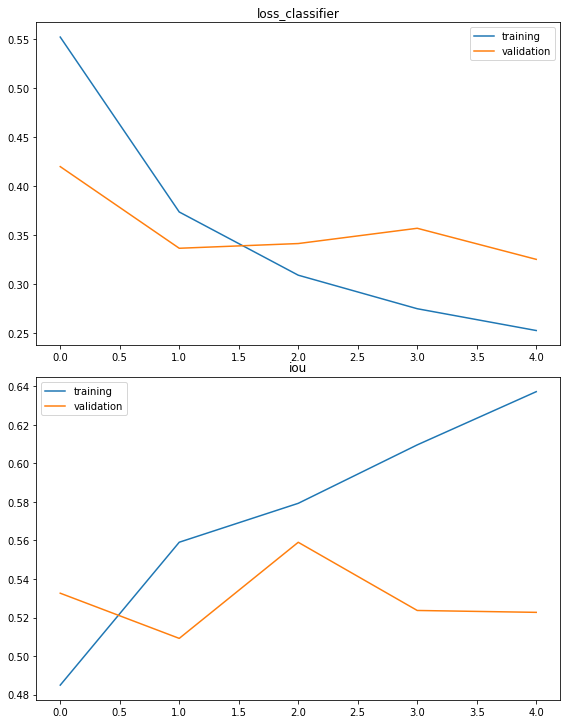

In [ ]:
fig, axs = plt.subplots(2, figsize= (8,10))
fig.tight_layout()
# loss_classifier
axs[0].plot(history_train['loss_classifier'], label = 'training')
axs[0].plot(history_val['loss_classifier'], label = 'validation')
axs[0].set_title("loss_classifier")
axs[0].legend()
# iou
axs[1].plot(history_train['iou'], label = 'training')
axs[1].plot(history_val['iou'], label = 'validation')
axs[1].set_title("iou")
axs[1].legend()

## 4.2 load best val (mIoU)

In [ ]:
net.load_state_dict(torch.load('./VOCDetection-FasterRCNN_MobileNet_V3.pth'))

<All keys matched successfully>

In [ ]:
# load finished weight 
# net.load_state_dict(torch.load('./VOCDetection-FasterRCNN_MobileNet_V3_master.pth'))

# 5. Testing (evaluation)

In [ ]:
    print('testing ...')
    mIoU = 0
    validation_loss = 0.0
    validation_loss_classifier = 0.0
    validation_loss_box_reg = 0.0
    validation_loss_objectness = 0.0
    validation_loss_rpn_box_reg = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            
            # find mIoU
            net.eval()
            preds = net(inputs)
            mIoU_sample, n_sample = miou(preds, labels)
            
            # loss
            net.train()
            loss_dict = net(inputs, labels)
            loss = sum(x for x in loss_dict.values())
            
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # aggregate statistics
            validation_loss += loss.item()*n_sample
            validation_loss_classifier += loss_dict['loss_classifier'].item()*n_sample
            validation_loss_box_reg += loss_dict['loss_box_reg'].item()*n_sample
            validation_loss_objectness += loss_dict['loss_objectness'].item()*n_sample
            validation_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()*n_sample
            mIoU += mIoU_sample*n_sample
            n += n_sample
    
    # print statistics
    validation_loss /= n
    validation_loss_classifier /= n
    validation_loss_box_reg /= n
    validation_loss_objectness /= n
    validation_loss_rpn_box_reg /= n
    mIoU /= n
    print(f"total_testing loss: {validation_loss:.4}, loss_classifier: {validation_loss_classifier:.4}, loss_box_reg: {validation_loss_box_reg:.4}, loss_objectness: {validation_loss_objectness:.4}, loss_rpn_box_reg: {validation_loss_rpn_box_reg:.4}, mIoU: {mIoU:.4}" )
    

testing ...


  0%|          | 0/79 [00:00<?, ?it/s]

total_testing loss: 0.7459, loss_classifier: 0.341, loss_box_reg: 0.359, loss_objectness: 0.03364, loss_rpn_box_reg: 0.01234, mIoU: 0.5591


# 6. show qualitative performance

In [ ]:
def imshow_test(imgs, preds, labels, ncol):
    nrow = len(imgs) // ncol
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*10, nrow*10))
    for row in range(nrow):
        for col in range(ncol):
            if row*ncol + col < len(imgs):
                img = imgs[row*ncol + col].cpu()*0.5 + 0.5
                img = img.permute((1, 2, 0)).mul(255).numpy()
                img = np.ascontiguousarray(img, dtype=np.uint8)
                
                boxes = labels[row*ncol + col]['boxes'].cpu().numpy()
                in_labels = labels[row*ncol + col]['labels'].cpu().numpy()
                nbox, _ = boxes.shape
                
                for i in range(nbox):
                    img = cv2.rectangle(img = img, 
                                        pt1 = (int(boxes[i][0]), int(boxes[i][1])), 
                                        pt2 = (int(boxes[i][2]), int(boxes[i][3])), 
                                        color = (0, 255, 0), 
                                        thickness = 2)
                    
                    img = cv2.putText(img = img, 
                                      text = f'{numlabel2text[in_labels[i]]}', 
                                      org = (int(boxes[i][0]) + 5, int(boxes[i][3]) - 5 ), 
                                      fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                                      fontScale = 1,
                                      color = (255, 255, 0), 
                                      thickness = 2, 
                                      lineType = cv2.LINE_AA)
                    
                boxes = preds[row*ncol + col]['boxes'].cpu().numpy()
                in_labels = preds[row*ncol + col]['labels'].cpu().numpy()
                confident = preds[row*ncol + col]['scores'].cpu().numpy()
                nbox, _ = boxes.shape
                
                for i in range(nbox):
                    if confident[i] > 0.5:
                        img = cv2.rectangle(img = img, 
                                            pt1 = (int(boxes[i][0]), int(boxes[i][1])), 
                                            pt2 = (int(boxes[i][2]), int(boxes[i][3])), 
                                            color = (255, 0, 0), 
                                            thickness = 2)
                    
                        img = cv2.putText(img = img, 
                                          text = f'{numlabel2text[in_labels[i]]}', 
                                          org = (int(boxes[i][0]) + 5, int(boxes[i][3]) - 5 ), 
                                          fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                                          fontScale = 1,
                                          color = (255, 0, 0),
                                          thickness = 2, 
                                          lineType = cv2.LINE_AA)
                
                ax[row, col].imshow(img)
                ax[row, col].axis('off')
            else:
                ax[row, col].imshow(np.zeros((200,200, 3), dtype = np.uint8))
                ax[row, col].axis('off')
    plt.show()

## 6.1 performance on training set

In [ ]:
with torch.no_grad():
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
            
    net.eval()
    preds = net(images)

# show images
ncol = 4
imshow_test(images, preds, labels, ncol)

Output hidden; open in https://colab.research.google.com to view.

## 6.2 performance on validation set

In [ ]:
with torch.no_grad():
    dataiter = iter(valloader)
    images, labels = next(dataiter)
            
    net.eval()
    preds = net(images)

# show images
ncol = 4
imshow_test(images, preds, labels, ncol)

Output hidden; open in https://colab.research.google.com to view.

## 6.3 performance on testing set

In [ ]:
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = next(dataiter)
            
    net.eval()
    preds = net(images)

# show images
ncol = 2
imshow_test(images, preds, labels, ncol)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = next(dataiter)
            
    net.eval()
    preds = net(images)

# show images
ncol = 2
imshow_test(images, preds, labels, ncol)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = next(dataiter)
    images, labels = next(dataiter)
            
    net.eval()
    preds = net(images)

# show images
ncol = 2
imshow_test(images, preds, labels, ncol)

Output hidden; open in https://colab.research.google.com to view.

# 7 performance on testing set with finished weight 

In [ ]:
net.load_state_dict(torch.load('./VOCDetection-FasterRCNN_MobileNet_V3_master.pth'))

In [ ]:
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = next(dataiter)
            
    net.eval()
    preds = net(images)

# show images
ncol = 2
imshow_test(images, preds, labels, ncol)

Output hidden; open in https://colab.research.google.com to view.